# Homework 3 - Which book would you recomend?

![alt text](img/SA_GR_SE_NL.png "")

##### **Authors:** Daniel Jiménez & Beatrice Nobille & Selim Yahiamessaoud
##### **Date:** 2020/12/06
##### **Subject:** Algorithmic Methods of Data Mining
##### **Data Science Master's programme**
##### **La Sapienza University of Rome**
_____

This file contains the solution to all the five Challenges (and its corresponding literals) required for the web scrapping and search engine creation for the Best Books ever list that you can find [HERE](https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1)

As like in any data-wrangling case, it's relevant to keep clean and tidy the working environment. We achieve this by explaining step-by-step the process we followed to crawl, parse and store the attributes of the books. 

**Notes:** 
- We worked on a PC with an SSD of 50 GB of free space and a RAM of 16 GB.

Well, first thing first, we set the libraries that we will be using to perform all the web scraping and search engine creation. 

# 1. Data collection

First things first. We import the required libraries to solve the challenges.

In [ ]:
# Import required libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.firefox import GeckoDriverManager
import time
import csv
from bs4 import BeautifulSoup
import requests
import pathlib
import math
import os
import pandas as pd
import numpy as np
import re
from langdetect import detect
import our_functions

## 1.1. Get the list of books

To get the list of the links for each book we followed the next steps:
1. We used `Selenium`, opening a browser (Firefox) to access to the main page where the list of the Best Books Ever
2. Then, we look for all the links that are on the page that contains '/book/show/' which have the URL we are looking for
3. As there are repeated links (appearing in links itself and in the photo of the book) we removed the duplicated values
4. After running in a loop the steps 2 and 3 for each of the 300 first pages, we stored them in the file **books_urls.txt** to be used later. We avoided saving two links of that were out of the list but inside the comments. Those books are *The War of the Worlds* and The *Shack*

Note: In some occasions, we used `time.sleep(n)` to force the PC to wait n seconds until the webpage has been completely loaded to avoid errors when looking for an object. 

In [ ]:
start_time = time.time()
# Open driver (in this case Firefox - need to be installed in the PC)
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())

# Open in Firefox the desired url
href = 'https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1'
driver.get(href)

# Pause execution while the page loads the content
time.sleep(12)

# Iterate over each page to retrieve book's links
urls = []
for i in range(300):
    partial_time1 = time.time()
    # Find all elements that contain a link inside a table (td)
    elements = driver.find_elements_by_xpath("//a[@href]")
    
    for elem in elements:
        # Retrieve the link
        link = elem.get_attribute("href")
        # Check if the link corresponds to a book
        if '/book/show/' in link:
            # Append each link found
            urls.append(link)
    
    # Click on "next" link to advance in each webpage
    driver.find_element_by_partial_link_text("next").click()
    
    # Pause execution while the page loads the content
    time.sleep(5)
    print("Retrieving page", i + 1, "/ 300 took", time.time() - partial_time1, "seconds")
    
# Remove duplicated links (keeping the order of appearence of each book's url)
# final_urls = list(set(urls))
final_urls = []
for i in urls:
    if i not in final_urls:
        final_urls.append(i)

# Close Firefox browser
driver.quit()

# Export links to txt file
with open('books_urls.txt', 'w') as f:
    for item in final_urls:
        # Avoid exporting the books added in the comments by the people (only two cases)
        if (item != 'https://www.goodreads.com/book/show/2510.The_War_of_the_Worlds' and item != 'https://www.goodreads.com/book/show/1812457.The_Shack'):
            f.write("%s\n" % item)

del urls, final_urls

print("--- %s seconds ---" % (time.time() - start_time))

[WDM] - Driver [C:\Users\Daniel_Jimenez\.wdm\drivers\geckodriver\win64\v0.28.0\geckodriver.exe] found in cache


Retrieving page 1 / 300 took 24.5305757522583 seconds
Retrieving page 2 / 300 took 31.544260501861572 seconds
Retrieving page 3 / 300 took 30.777462482452393 seconds
Retrieving page 4 / 300 took 27.54737663269043 seconds
Retrieving page 5 / 300 took 30.077595710754395 seconds
Retrieving page 6 / 300 took 26.381412029266357 seconds
Retrieving page 7 / 300 took 26.7865309715271 seconds
Retrieving page 8 / 300 took 24.992651224136353 seconds
Retrieving page 9 / 300 took 29.19309949874878 seconds
Retrieving page 10 / 300 took 28.588332414627075 seconds
Retrieving page 11 / 300 took 28.364408493041992 seconds
Retrieving page 12 / 300 took 27.344547986984253 seconds
Retrieving page 13 / 300 took 26.75330424308777 seconds
Retrieving page 14 / 300 took 29.226094007492065 seconds
Retrieving page 15 / 300 took 26.680985689163208 seconds
Retrieving page 16 / 300 took 25.645787715911865 seconds
Retrieving page 17 / 300 took 25.48965358734131 seconds
Retrieving page 18 / 300 took 24.455013275146484

As shown, the process took a bit more that 2 hours. Now we are ready to crawl the books.

## 1.2. Crawl books
Now, we need to download in our PC, like HTML, all webpages for each of the books' URL retrieved. To do so, we followed the next way of thinking:

1. First, we need to upload the *books_urls.txt* containing the links to each book
2. Later, we create from Python the 300 folders to store each of the HTML files
3. With the combination of `BeautifulSoup` and `requests` we retrieved the content of each HTML to Python
4. Automatically, we stored each HTML file in the respective folder in our PC, to keep it tidy
5. The points 3 and 4 were executed for each of the 30.000 URLs

Note: To run this process, we proceeded to create 4 different sessions in a single computer and executed the loop by chunks. In each chunk, we had to retrieve 7500 URLs. We used this "parallelization" technique to reduce the execution time.  

In [ ]:
# Read the file containing retrieved URLs
with open('books_urls.txt', newline='') as f:
    reader = csv.reader(f)
    final_urls = list(reader)

In [ ]:
start_time = time.time()
# Create 300 folders to store the HTML files
for i in range(300):
    # Define path to create folders
    newpath = os.getcwd() + r'\data\HTML_files\page_' + str(i + 1)
    # Check if folder exists, if not, create it
    if not os.path.exists(newpath):
        os.makedirs(newpath)

# Populate each folder with the corresponding HTML books
for i in range(len(final_urls)):
# for i in range(14620,14621):
# for i in [23543,23918,23998,24472,25747,27954]:
    partial_time1 = time.time()
    # Get the link to retrieve
    link = ' '.join(map(str, final_urls[i]))
    
#     print(link)
    # Request the webpage
    page = requests.get(link)
    # Parse page to soup format
    soup = BeautifulSoup(page.text, features='lxml')
    # Calculate the page of the corresponding book
    page = math.ceil((i + 1) / 100)
    
    # Save each webpage as HTML in our PC
    f = open(r"data/HTML_files/page_" + str(page) + r"/book_" + str(i + 1) + r".html", "w", encoding='utf-8')
    f.write(str(soup.prettify()))
    f.close()
    
    print("Processing book", i + 1, "/ 30000 took", time.time() - partial_time1, "seconds")

print("--- %s seconds ---" % (time.time() - start_time))

Processing book 23544 / 30000 took 1.2755396366119385 seconds
Processing book 23919 / 30000 took 0.4957573413848877 seconds
Processing book 23999 / 30000 took 1.281550407409668 seconds
Processing book 24473 / 30000 took 0.9667823314666748 seconds
Processing book 25748 / 30000 took 1.3054816722869873 seconds
Processing book 27955 / 30000 took 1.397230625152588 seconds
--- 6.751603603363037 seconds ---


The previous process consumed a total of 3 hours to download the 30.000 webpages. The next step is to parse all the information of the HTML files downloaded.

## 1.3 Parse downloaded pages


At this point, we are challenged to execute the parsing. It means, extract relevant information regarding the books that are stored in the HTML files. 

First, we defined a function that let us find and retrieve some interesting pieces of information regarding the books (12 attributes). The `scrap_book` function is a modification of the one that we created in LAB class. The latter is leveraged in the use of `find_all` functionality provided by `BeautifullSoup`. Besides, we included some `Try/Except` steps to handle the possible errors when any of the desired attributes of the book don't exist. Furthermore, we used the `langdetect` library to find out the language of each book's description. The definition of this function can be found in the file *our_functions.py*

Later, we continued with the next phases:
    
1. We used the function mentioned above to get the attributes for each book
2. Then, we appended in a .tsv file the result of the retrieved information of every book, separated by \t (TAB)
3. The prebious phases where executed for the whole 30.000 books

Note: Again, we proceeded to initiate 4 sessions in a single computer and executed the loop by chunks. In each chunk, we had to look for the information of 7500 books each. As a result, we will have 4 .tsv files that need to be appended later.

In [ ]:
start_time = time.time()

for i in range(0, 7500):
# for i in range(14,16):
    partial_time1 = time.time()

    # Calculate the page of the corresponding book
    page = math.ceil((i + 1) / 100)
    
    # Get the HTML of each book
    path = r"data/HTML_files/page_" + str(page) + r"/book_" + str(i + 1) + r".html"
    
    # Scrap the content
    info_book = our_functions.scrap_book(path)
    
    # Add the URL
    info_book = info_book + final_urls[i]
#     print(info_book)
    info_book =  '\t'.join(map(str,info_book)) + " \n"
    
    # Write in the txv file
    with open("data/tsv _files/final_df_1.tsv", "a", encoding='utf-8') as record_file:
        record_file.write(info_book)
    
    print("Processing book", i + 1, "/ 30000 took", time.time() - partial_time1, "seconds")

print("--- %s seconds ---" % (time.time() - start_time))

Processing book 1 / 30000 took 1.7022335529327393 seconds
Processing book 2 / 30000 took 1.4291777610778809 seconds
Processing book 3 / 30000 took 0.8537194728851318 seconds
Processing book 4 / 30000 took 1.0043158531188965 seconds
Processing book 5 / 30000 took 1.0651531219482422 seconds
Processing book 6 / 30000 took 1.2147505283355713 seconds
Processing book 7 / 30000 took 0.7482569217681885 seconds
Processing book 8 / 30000 took 1.0801126956939697 seconds
Processing book 9 / 30000 took 0.5096359252929688 seconds
Processing book 10 / 30000 took 0.5934140682220459 seconds
Processing book 11 / 30000 took 0.873664379119873 seconds
Processing book 12 / 30000 took 0.6901562213897705 seconds
Processing book 13 / 30000 took 0.5106661319732666 seconds
Processing book 14 / 30000 took 0.885603666305542 seconds
Processing book 15 / 30000 took 0.710101842880249 seconds
Processing book 16 / 30000 took 0.6263227462768555 seconds
Processing book 17 / 30000 took 0.598400354385376 seconds
Processing

The preceding code took 3 hours to run for the 30.000 books. Now it is time to append all the information in one single table.

As mentioned, to create a single data frame with the information parsed from the 30.000 books, we uploaded each .tsv file and appended them in a pandas object. Later, we deleted duplicated caused for multiple runs over the same book. Then we keep only the books with valid information since some links didn't have the correct structure to be scraped. Afterwards, we validated if the plot of the books was in English. To do so, we used the `langdetect` to get the descriptions matching with *en* (English). As a final step, we saved the file in a .tsv file that contains the whole books.

In [ ]:
start_time = time.time()
# Upload both parts of the books' information providing the corresponding name of each column
colnames = ['book_title', 'bookSeries', 'bookAuthors', 'ratingValue', 'ratingCount', 'reviewCount', 'Plot', 'NumberofPages', 'PublishingDate', 'Characters', 'Setting','language','Url']
data = pd.read_csv("data/tsv _files/final_df_1.tsv", sep="\t", names=colnames, header=None, encoding='utf-8')
data_part2 = pd.read_csv("data/tsv _files/final_df_2.tsv", sep="\t", names=colnames, header=None, encoding='utf-8')
data_part3 = pd.read_csv("data/tsv _files/final_df_3.tsv", sep="\t", names=colnames, header=None, encoding='utf-8')
data_part4 = pd.read_csv("data/tsv _files/final_df_4.tsv", sep="\t", names=colnames, header=None, encoding='utf-8')

# Append all dataframes in a single one
data = data.append(data_part2)
data = data.append(data_part3)
data = data.append(data_part4)
del data_part2, data_part3, data_part4

# Delete duplicates caused by multiple runs over the same book
data = data.drop_duplicates()

# Keep the books that have valid information
data = data[data['book_title'].notnull()]

# Check that all the books has an URL
data = data[data['Url'].notnull()]

# Keep only the books which plot is in english
data = data[data['language'] == 'en']

# Export final table to be used in the next points
data.to_csv("data/final_file/all_books_information.tsv", sep = "\t", index=False)
print(data.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(26568, 13)
--- 1.931851863861084 seconds ---


Finally, we scraped the information about 26568 books (removing those without information and which plot is not in English). Now we are ready to proceed with the creation of our search engines.

# 2. Search Engine

In [1]:
# Import libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import time
import csv
from bs4 import BeautifulSoup
import requests
import pathlib
import math
import os
import pandas as pd
import numpy as np
import re
import heapq

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Import Data 
books_info = pd.read_csv("all_books_information.tsv", sep="\t", header=0, encoding='utf8')

books_info.head()

,book_title,bookSeries,bookAuthors,ratingValue,ratingCount,reviewCount,Plot,NumberofPages,PublishingDate,Characters,Setting,language,Url
0,The Hunger Games,(The Hunger Games #1),Suzanne Collins,4.33,"6,408,019","172,545",In the ruins of a place once known as North Am...,374,September 14th 2008,"Katniss Everdeen, Peeta Mellark, Cato (Hunger ...","District 12, Panem - Capitol, Panem - Panem",en,https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,(Harry Potter #5),"J.K. Rowling, Mary GrandPré",4.50,"2,524,357","42,719",There is a door at the end of a silent corrido...,870,September 2004,"Sirius Black, Draco Malfoy, Ron Weasley, Petun...",Hogwarts School of Witchcraft and Wizardry - L...,en,https://www.goodreads.com/book/show/2.Harry_Po...
2,To Kill a Mockingbird,(To Kill a Mockingbird),Harper Lee,4.28,"4,526,703","91,786",The unforgettable novel of a childhood in a sl...,324,May 23rd 2006,"Scout Finch, Atticus Finch, Jem Finch, Arthur ...","Maycomb, Alabama",en,https://www.goodreads.com/book/show/2657.To_Ki...
3,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen",4.26,"3,016,917","67,784","Since its immediate success in 1813, ...",279,October 10th 2000,"Mr. Bennet, Mrs. Bennet, Jane Bennet, Elizabet...","United Kingdom - Derbyshire, England - England...",en,https://www.goodreads.com/book/show/1885.Pride...
4,Twilight,(The Twilight Saga #1),Stephenie Meyer,3.60,"4,988,910","104,902",About three things I was absolutely positive. ...,501,September 6th 2006,"Edward Cullen, Jacob Black, Laurent, Renee, Be...","Forks, Washington - Phoenix, Arizona - Washing...",en,https://www.goodreads.com/book/show/41865.Twil...


## Text pre-processing

Now, we want to create two different Search Engines that, given as input a query, return the books that match the query.

First, we must pre-process all the information collected for each book by
1. Removing stopwords
2. Removing punctuation
3. Convert to lowercase
4. 'Manually' stem common irregular verbs (regular stemmers do not consider irregular verbs, so we have downoaded a table of irregular verbs, and did the stemming 'manually')
5. Stemming
6. Removing stemmed words that have length less or equal to 2 (e.g., single letters)


In [3]:
stop_words = set(stopwords.words('english'))
stemming = PorterStemmer()

# Tokenization
def tokenize_row(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words


# Stemming of irregular verbs
irregulars = pd.read_csv("irregular_verbs.csv", sep=";", header=0, encoding='utf8')
irregulars.columns = ['inf', 'sp', 'pp']

def irregular_verbs(row):
    new_row = []
    for word in row:
      if word not in irregulars['sp'].to_list() and word not in irregulars['pp'].to_list():
        new_row.append(word)
        continue
      else:
        for i in range(irregulars.shape[0]):
          if word == irregulars['sp'][i]:
            new_row.append(irregulars['inf'][i])
            continue
          if word == irregulars['pp'][i]:
            new_row.append(irregulars['inf'][i])
            continue
    return new_row


# Before stemming remove capitalization and retain only terms that are more than 2 letters
def stem_row(row):
    stemmed_list = [stemming.stem(word.lower()) for word in row if len(stemming.stem(word.lower()))>2]
    return stemmed_list

# Remove stopwords
def rm_stopwords_row(row):
    meaningful_words = [w for w in row if not w in stop_words]
    return meaningful_words

In [4]:
# Application and examples
books_info['Plot'] = books_info['Plot'].apply(tokenize_row)
print(books_info['Plot'][0])

books_info['Plot'] = books_info['Plot'].apply(irregular_verbs)
print(books_info['Plot'][0])

books_info['Plot'] = books_info['Plot'].apply(stem_row)
print(books_info['Plot'][0])

books_info['Plot'] = books_info['Plot'].apply(rm_stopwords_row)
print(books_info['Plot'][0])

['In', 'the', 'ruins', 'of', 'a', 'place', 'once', 'known', 'as', 'North', 'America', 'lies', 'the', 'nation', 'of', 'Panem', 'a', 'shining', 'Capitol', 'surrounded', 'by', 'twelve', 'outlying', 'districts', 'The', 'Capitol', 'is', 'harsh', 'and', 'cruel', 'and', 'keeps', 'the', 'districts', 'in', 'line', 'by', 'forcing', 'them', 'all', 'to', 'send', 'one', 'boy', 'and', 'one', 'girl', 'between', 'the', 'ages']
['In', 'the', 'ruins', 'of', 'a', 'place', 'once', 'know', 'as', 'North', 'America', 'lies', 'the', 'nation', 'of', 'Panem', 'a', 'shining', 'Capitol', 'surrounded', 'by', 'twelve', 'outlying', 'districts', 'The', 'Capitol', 'is', 'harsh', 'and', 'cruel', 'and', 'keeps', 'the', 'districts', 'in', 'line', 'by', 'forcing', 'them', 'all', 'to', 'send', 'one', 'boy', 'and', 'one', 'girl', 'between', 'the', 'ages']
['the', 'ruin', 'place', 'onc', 'know', 'north', 'america', 'lie', 'the', 'nation', 'panem', 'shine', 'capitol', 'surround', 'twelv', 'outli', 'district', 'the', 'capitol'

As we can see, we first tokenize the words, i.e. we remove puntuations, and we split the string into a list of single separated words, then we stem the irregular verbs, thirdly we remove the capitalization and we stem the words using the Porter stemmer, and we retain only those tokens that are composed of at least 3 letters. Finally, we remove the stop words. 

## 2.1. Conjunctive query


### 2.1.1 Creating the index


First we compute the list called vocabulary containing all the possible words in our corpus.

In [5]:
vocabulary = []
for plot in books_info['Plot']:
  for word in plot :
    if word not in vocabulary:
      vocabulary.append(word)

vocabulary.remove('nan')

We then create the Inverted index by zipping matching the vocabulary list with the document_ids containing the word. There are no duplicates in our dict (ie. if a word appears two time in a plot it makes no difference it this first index)

In [6]:
dict_values=[[]for _ in range(len(vocabulary))] #for each word of the vocabulary we'll save which plot contain it (document_id)

document_id=0
for plot in books_info['Plot']:
  for w0rd in plot:
    if w0rd != 'nan':
      index=vocabulary.index(w0rd)
      if document_id not in dict_values[index]:
        dict_values[index].append(document_id)
  document_id+=1

ids = ['-'.join(map(str, i)) for i in dict_values]
Inverted_index=dict(zip(vocabulary, ids))

##### We exported all the heavy files, so that we didn't need to rerun them every time.

In [7]:
i_idx = pd.DataFrame()
i_idx['term'] = Inverted_index.keys()
i_idx['doc_ids'] = Inverted_index.values()

i_idx.to_csv('inverted_index.csv', index = False)

### 2.1.2 Executing the query


##### The first thing is to upload the inverted index

In [8]:
inv = pd.read_csv('inverted_index.csv')
Inverted_index = inv.set_index('term').to_dict()
Inverted_index = Inverted_index['doc_ids']
for i in list(Inverted_index.keys()):
  if type(Inverted_index[i])!= float:
    Inverted_index[i] = list(map(int, Inverted_index[i].split('-')))

We ask the user to input a query. Note that the query words need to go through the stemming process too otherwise we will not be able to match them properly.

In [9]:
query = input("What kind of book are you looking for ?\n")
query=nltk.word_tokenize(query)
query = [stemming.stem(word) for word in query]
print(query)

What kind of book are you looking for ?
survival games
['surviv', 'game']


In [10]:
results=[]
for word in query:
  if word in Inverted_index.keys():
    for document_id in Inverted_index[word] :
      results.append(books_info[['book_title','Plot','Url']].iloc[document_id])

result_df= pd.concat(results, axis=1)
result_df=result_df.T #we transpose the dataframe to plot it as specified in the hw description
result_df.head(20)

,book_title,Plot,Url
52,Life of Pi,"[life, fantasi, adventur, novel, yann, martel,...",https://www.goodreads.com/book/show/4214.Life_...
66,Watership Down,"[set, england, onc, idyl, rural, landscap, thi...",https://www.goodreads.com/book/show/76620.Wate...
68,Little Women,"[gener, reader, young, old, male, femal, fall,...",https://www.goodreads.com/book/show/1934.Littl...
84,Angela's Ashes,"[imbu, everi, page, frank, mccourt, astound, h...",https://www.goodreads.com/book/show/252577.Ang...
175,The Titan's Curse,"[everyday, find, combat, son, greek, god, happ...",https://www.goodreads.com/book/show/561456.The...
179,The Call of the Wild,"[first, publish, regard, jack, london, masterp...",https://www.goodreads.com/book/show/1852.The_C...
219,Catching Fire,"[odd, katniss, everdeen, surviv, hunger, game,...",https://www.goodreads.com/book/show/6148028-ca...
235,Man's Search for Meaning,"[psychiatrist, viktor, frankl, memoir, rivet, ...",https://www.goodreads.com/book/show/4069.Man_s...
315,A Court of Mist and Fury,"[feyr, surviv, amarantha, clutch, return, spri...",https://www.goodreads.com/book/show/17927395-a...
318,Mockingjay,"[final, book, hunger, game, trilog, thi, new, ...",https://www.goodreads.com/book/show/7260188-mo...


## 2.2  Conjunctive query & Ranking score


## 2.2.1 Inverted index and TF-IDF score

Our goal is to get a matching score for each book and to plot the top-k article. To compute this matching score, we use the tfidf score and the cosine similarity.

Check this document for more info on matching score computation (material recommended by the professor) : https://nlp.stanford.edu/IR-book/pdf/06vect.pdf

In [11]:
#tf-idf 
tf_idf = {}
N = books_info.shape[0]

for key, value in Inverted_index.items():
  if type(key) != float:
    tf_idf[key] = [' '.join(books_info['Plot'][i]).count(key)*(np.log(N/len(value))) for i in value]

#Query

tf_idf_q = {}
for i in query:
  tf_idf_q[i] = " ".join(query).count(i)*(np.log(N/len(Inverted_index[i])))

Here we are creating a vector for the query, and a vector for each document. In particular, this vectors will have the same length as the vocabulary, and they will have zeros if the query/document does not contain the vocabulary term, or the tf-idf score for that particular combination of word-document (or word-query). 

In [12]:
# Create Vectors for Query and Documents
documents = books_info['book_title'].to_list()

query_vec = []

for i in vocabulary:
  if i in query:
    query_vec.append(tf_idf_q[i])
  else:
    query_vec.append(0)

doc_vec = {}

for doc in range(len(documents)):
  doc_vec[doc] = []
  for i in vocabulary:
    if doc in Inverted_index[i]:
      idx = Inverted_index[i].index(doc)
      doc_vec[doc].append(tf_idf[i][idx])
    else:
      doc_vec[doc].append(0)

### Results

In [13]:
df = pd.DataFrame()
df['title'] = documents
df['Plot'] = books_info['Plot']
df['similarity'] = [np.dot(doc_vec[i], query_vec)/(np.linalg.norm(doc_vec[i])*np.linalg.norm(query_vec)) for i in range(df.shape[0])]
df['url'] = books_info['Url']

#ranking
sim_lst = [-i for i in df['similarity'].to_list()]
heapq.heapify(sim_lst)
ranking = [-round(i, 3) for i in sim_lst]
df['similarity'] = ranking

#output

k = 20
df.sort_values(['similarity'], ascending = False).head(k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,title,Plot,similarity,url
0,The Hunger Games,"[ruin, place, onc, know, north, america, lie, ...",0.408,https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,"[door, end, silent, corridor, haunt, harri, po...",0.400,https://www.goodreads.com/book/show/2.Harry_Po...
2,To Kill a Mockingbird,"[unforgett, novel, childhood, sleepi, southern...",0.390,https://www.goodreads.com/book/show/2657.To_Ki...
3,Pride and Prejudice,"[sinc, immedi, success, remain, one, popular, ...",0.383,https://www.goodreads.com/book/show/1885.Pride...
4,Twilight,"[three, thing, absolut, posit, first, edward, ...",0.363,https://www.goodreads.com/book/show/41865.Twil...
5,The Book Thief,"[nazi, germani, countri, hold, breath, death, ...",0.347,https://www.goodreads.com/book/show/19063.The_...
9,The Fault in Our Stars,"[despit, medic, miracl, buy, year, hazel, neve...",0.338,https://www.goodreads.com/book/show/11870085-t...
6,Animal Farm,"[farm, take, overwork, mistreat, anim, flame, ...",0.322,https://www.goodreads.com/book/show/170448.Ani...
11,The Hitchhiker's Guide to the Galaxy,"[second, befor, earth, demolish, make, way, ga...",0.316,https://www.goodreads.com/book/show/386162.The...
12,The Giving Tree,"[onc, tree, love, littl, boy, begin, stori, un...",0.300,https://www.goodreads.com/book/show/370493.The...


# 3. Define a new score!

## Inverted Indexes


##### First of all we have computed the inverted indeces for Authors and Settings, because we will use them for a primary filtering of the data.

In [ ]:
######### Authors ############
authors = books_info['bookAuthors'].to_list() # get the list of all authors
authors_ = [i.lower().split(', ') for i in authors] #normalize strings, and separate different authors beloging to the same book
flat_list = set([item for sublist in authors_ for item in sublist]) #remove duplicates and flatten the list of lists

inv_idx_authors = {}

#For every author, we get the list of indexes of the books where he/she is an author
for author in flat_list:
  inv_idx_authors[author] = '-'.join(map(str, list(books_info[books_info['bookAuthors'].str.contains(author, case= False)].index)))

# Saving an external csv
i_idx = pd.DataFrame()
i_idx['author'] = inv_idx_authors.keys()
i_idx['doc_ids'] = inv_idx_authors.values()

i_idx.to_csv('inverted_index_authors.csv', index = False)


######### Settings ############
places = books_info['Setting'].dropna().to_list()
places_ = [re.split(r', | - |\(|\)', i.lower()) for i in places]
flat_lst = set([item for sublist in places_ for item in sublist if item != ''])

inv_idx_setting = {}

for place in flat_lst:
  inv_idx_setting[place] = '-'.join(map(str, list(books_info[books_info['Setting'].str.contains(place, case= False, na = False)].index)))


i_idx = pd.DataFrame()
i_idx['setting'] = inv_idx_setting.keys()
i_idx['doc_ids'] = inv_idx_setting.values()

i_idx.to_csv('inverted_index_settings.csv', index = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [17]:
# import the inverted index, turn it into a dictionary, convert the doc_ids into lists
idx_genre = pd.read_csv('inverted_index.csv')
idx_genre = idx_genre.set_index('term').to_dict()
idx_genre = idx_genre['doc_ids']
for i in list(idx_genre.keys()):
  if type(idx_genre[i])!= float:
    idx_genre[i] = list(map(int, idx_genre[i].split('-')))

idx_author = pd.read_csv('inverted_index_authors.csv')
idx_author = idx_author.set_index('author').to_dict()
idx_author = idx_author['doc_ids']
for i in list(idx_author.keys()):
  if type(idx_author[i])!= float:
    idx_author[i] = list(map(int, idx_author[i].split('-')))

idx_setting = pd.read_csv('inverted_index_settings.csv')
idx_setting = idx_setting.set_index('setting').to_dict()
idx_setting = idx_setting['doc_ids']
for i in list(idx_setting.keys()):
  if type(idx_setting[i])!= float:
    idx_setting[i] = list(map(int, idx_setting[i].split('-')))

## Dataset

##### We import again the dataset and we clean it this time, because we will be using more columns

In [18]:
# Import Data 
books_info = pd.read_csv("all_books_information.tsv", sep="\t", header=0, encoding='utf8')

# Data Cleaning (converting to the correct types, and handling missing values)
books_info.fillna(0, inplace= True)
books_info['reviewCount'] = [int(i.replace(',', '')) for i in books_info['reviewCount']]
books_info['ratingCount'] = [int(i.replace(',', '')) for i in books_info['ratingCount']]
books_info['ratingValue'] = books_info['ratingValue'].astype(float)
books_info['NumberofPages'] = books_info['NumberofPages'].replace('1 page','1').astype(float)

# Normalization
mi = books_info['ratingCount'].min()
ma = books_info['ratingCount'].max()
books_info['ratingCount']= [(i-mi)/(ma-mi) for i in books_info['ratingCount']]

mi = books_info['reviewCount'].min()
ma = books_info['reviewCount'].max()
books_info['reviewCount']= [(i-mi)/(ma-mi) for i in books_info['reviewCount']]

books_info.head()

,book_title,bookSeries,bookAuthors,ratingValue,ratingCount,reviewCount,Plot,NumberofPages,PublishingDate,Characters,Setting,language,Url
0,The Hunger Games,(The Hunger Games #1),Suzanne Collins,4.33,0.903080,1.000000,In the ruins of a place once known as North Am...,374.0,September 14th 2008,"Katniss Everdeen, Peeta Mellark, Cato (Hunger ...","District 12, Panem - Capitol, Panem - Panem",en,https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,(Harry Potter #5),"J.K. Rowling, Mary GrandPré",4.50,0.355757,0.247582,There is a door at the end of a silent corrido...,870.0,September 2004,"Sirius Black, Draco Malfoy, Ron Weasley, Petun...",Hogwarts School of Witchcraft and Wizardry - L...,en,https://www.goodreads.com/book/show/2.Harry_Po...
2,To Kill a Mockingbird,(To Kill a Mockingbird),Harper Lee,4.28,0.637947,0.531954,The unforgettable novel of a childhood in a sl...,324.0,May 23rd 2006,"Scout Finch, Atticus Finch, Jem Finch, Arthur ...","Maycomb, Alabama",en,https://www.goodreads.com/book/show/2657.To_Ki...
3,Pride and Prejudice,0,"Jane Austen, Anna Quindlen",4.26,0.425173,0.392848,"Since its immediate success in 1813, ...",279.0,October 10th 2000,"Mr. Bennet, Mrs. Bennet, Jane Bennet, Elizabet...","United Kingdom - Derbyshire, England - England...",en,https://www.goodreads.com/book/show/1885.Pride...
4,Twilight,(The Twilight Saga #1),Stephenie Meyer,3.60,0.703086,0.607969,About three things I was absolutely positive. ...,501.0,September 6th 2006,"Edward Cullen, Jacob Black, Laurent, Renee, Be...","Forks, Washington - Phoenix, Arizona - Washing...",en,https://www.goodreads.com/book/show/41865.Twil...


##### Following we have the query, which is variable, and will depend on the user's input

In [24]:
# Query

plot = stemming.stem(input("What genre would you like? This is necessary, please express a preference. ").lower())
author = stemming.stem(input("Do you like a particular author? Leave blank if not. ").lower())
setting = stemming.stem(input("Are you interested in a particular location? Leave blank if not. ").lower())
rate = input("Considering a scale of 5, would like to have a minimum rating value? Leave blank if not. ")
pages = input("Do you want the book to have a maximum number of pages? Leave blank if not. ")

query = {'plot': plot, 'author': author, 'setting': setting, 'rate': rate, 'pages': pages}

real_query = {}

for key, value in query.items():
  if value != '':
    real_query[key] = value

print(real_query)

What genre would you like? This is necessary, please express a preference. romance
Do you like a particular author? Leave blank if not. Lee
Are you interested in a particular location? Leave blank if not. 
Considering a scale of 5, would like to have a minimum rating value? Leave blank if not. 3.5
Do you want the book to have a maximum number of pages? Leave blank if not. 300
{'plot': 'romanc', 'author': 'lee', 'rate': '3.5', 'pages': '300'}


## Filtering

##### According to the user's input, we filter the data so that it contains only those elements that it has specified, but not necessarily together. For example, if the user has specified a specific author, that does NOT mean that we will be considering only that author.



In [25]:
potential_books = idx_genre[plot]
if 'author' in real_query.keys():
  potential_books += idx_author[[i for i in list(idx_author.keys()) if re.search(author, i)][0]]

if 'setting' in real_query.keys():
  potential_books += idx_setting[[i for i in list(idx_setting.keys()) if re.search(setting, i)][0]]

potential_books = list(set(potential_books))
no_priority  = books_info[books_info.index.isin(potential_books)]

no_priority.head()

,book_title,bookSeries,bookAuthors,ratingValue,ratingCount,reviewCount,Plot,NumberofPages,PublishingDate,Characters,Setting,language,Url
44,A Game of Thrones,(A Song of Ice and Fire #1),George R.R. Martin,4.45,0.283683,0.316630,Here is the first volume in George R. R. Marti...,835.0,August 2005,"Brandon Stark, Catelyn Stark, Tyrion Lannister...",The Lands of Ice and Fire,en,https://www.goodreads.com/book/show/13496.A_Ga...
55,Lolita,0,"Vladimir Nabokov, Craig Raine",3.89,0.093881,0.144061,"Humbert Humbert - scholar, aesthete and romant...",331.0,1995,"Humbert Humbert, Dolores “Lolita” Haze, Charlo...",United States of America,en,https://www.goodreads.com/book/show/7604.Lolita
63,The Pillars of the Earth,(Kingsbridge #1),Ken Follett,4.31,0.091992,0.182039,Everything readers expect from Follett is here...,976.0,February 4th 2002,"Thomas Becket, Henry II of England, Tom Builde...",England,en,https://www.goodreads.com/book/show/5043.The_P...
89,Don Quixote,0,"Miguel de Cervantes Saavedra, John Rutherford,...",3.88,0.029758,0.047269,Don Quixote has become so entranced by reading...,1023.0,February 25th 2003,"Sancho Panza, Don Quijote de la Mancha","La Mancha - Barcelona, Catalonia - Spain",en,https://www.goodreads.com/book/show/3836.Don_Q...
131,"Hush, Hush","(Hush, Hush #1)",Becca Fitzpatrick,3.96,0.081372,0.144919,Romance was not part of Nora Grey s plan. She ...,391.0,October 13th 2009,"Nora Grey, Jev ""Patch"" Cipriano, Vee Sky, Marc...","Coldwater, Maine",en,https://www.goodreads.com/book/show/6339664-hu...


## Executing the Query


##### Now that we have a filtered dataset, we can work on it for executing the query. The first thing we do is computing the similarity for the 'plot' now considered the genre of the book. There could be more genres too, but the point is that we are only computing it for a screened number of books.

In [26]:
query_vec = []
N = len(vocabulary)


tf_idf_q = {}
for i in [plot]:
  tf_idf_q[i] = " ".join([plot]).count(i)*(np.log(N/len(idx_genre[i])))

for i in vocabulary:
  if i in [plot]:
    query_vec.append(tf_idf_q[i])
  else:
    query_vec.append(0)

genre_similarity = [np.dot(doc_vec[i], query_vec)/(np.linalg.norm(doc_vec[i])*np.linalg.norm(query_vec)) for i in no_priority.index]

Now, depending on the elements that the user is interested in, we modify the similarity accordingly, giving specific weight to each of the elements the user has specified. In particular:
* The genre is the most important element and it accounts for 40%
* If the user has specified the name of the author, then if a specific book has been written by that author, it's similarity will increase according to a weight of 0.15.
* If the user has specified the setting, then the books that are set in that particular location will have their similarity increase according to a weight of 0.1
* If the user has specified a minimum rate, then the rate (weighted by the normalized 'ratingCount' and 'reviewCount') will be divided by the minimum weight specified by the user, so that the similarity score will increase if the rating is bigger or equal to the minimum specified by the user, or decrease otherwise.
* Similarly, if the user has specified a maximum number of pages, then the similarity scores will decrease for books that are longer than the specified number of pages, and increase otherwise.

In [27]:
all_similarity = []
weight = 0.4

if 'author' in real_query.keys():
  author_sim = []
  for i in no_priority.index:
    if bool(re.search(author, no_priority['bookAuthors'][i])):
      author_sim.append(0.15)
    else:
      author_sim.append(0)
  all_similarity.append(author_sim)
else:
  weight += 0.15


if 'setting' in real_query.keys():
  setting_sim = []
  for i in no_priority.index:
    if type(no_priority['Setting'][i]) != int:
      if bool(re.search(setting, no_priority['Setting'][i])):
        setting_sim.append(0.1)
      else:
        setting_sim.append(0)
    else:
      setting_sim.append(0)
  all_similarity.append(setting_sim)
else:
  weight += 0.1

if 'rate' in real_query.keys():
  rate = float(rate)
  rating_sim = [(0.1*(no_priority['ratingValue'][i]/rate)*(1+no_priority['ratingCount'][i])*(1+no_priority['reviewCount'][i])) for i in no_priority.index]
  all_similarity.append(rating_sim)
else:
  weight +=0.1
                           
if 'pages' in real_query.keys():
  pages = float(pages)
  page_sim = [0.05 * (0.1*(1 - no_priority['NumberofPages'][i]/pages)) for i in no_priority.index]
  all_similarity.append(page_sim)
else:
  weight += 0.05

Finally, we put everything together and we print the results.

In [28]:
other_elem = np.array([sum(x) for x in zip(*all_similarity)])
genre_similarity = np.array(genre_similarity)


similarity = (other_elem)+(weight*genre_similarity)
no_priority['similarity'] = similarity

#ranking
new_sim_lst = [-i for i in no_priority['similarity'].to_list()]
heapq.heapify(new_sim_lst)
ranking = [-round(i, 3) for i in new_sim_lst]
no_priority['similarity'] = ranking

#output
no_priority = no_priority[['book_title', 'Plot', 'Url', 'similarity']]

k = 20
no_priority.sort_values(['similarity'], ascending = False).head(k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,book_title,Plot,Url,similarity
44,A Game of Thrones,Here is the first volume in George R. R. Marti...,https://www.goodreads.com/book/show/13496.A_Ga...,0.412
55,Lolita,"Humbert Humbert - scholar, aesthete and romant...",https://www.goodreads.com/book/show/7604.Lolita,0.390
131,"Hush, Hush",Romance was not part of Nora Grey s plan. She ...,https://www.goodreads.com/book/show/6339664-hu...,0.372
63,The Pillars of the Earth,Everything readers expect from Follett is here...,https://www.goodreads.com/book/show/5043.The_P...,0.339
89,Don Quixote,Don Quixote has become so entranced by reading...,https://www.goodreads.com/book/show/3836.Don_Q...,0.329
624,Possession,"is an exhilarating novel of wit and romance, a...",https://www.goodreads.com/book/show/41219.Poss...,0.323
578,Cyrano de Bergerac,This is Edmond Rostand s immortal play in whic...,https://www.goodreads.com/book/show/15638.Cyra...,0.322
1102,The Blue Castle,An unforgettable story of courage and romance....,https://www.goodreads.com/book/show/95693.The_...,0.322
479,Bleak House,Bleak House opens in the twilight of foggy Lon...,https://www.goodreads.com/book/show/31242.Blea...,0.314
395,Like Water for Chocolate,"Earthy, magical, and utterly charming, this ta...",https://www.goodreads.com/book/show/6952.Like_...,0.292


# 4. Not so nice Visualization

### Data Cleaning

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

books_info = pd.read_csv("all_books_information.tsv", sep="\t", header=0, encoding='utf8')
sub_df = books_info[['bookSeries', 'NumberofPages', 'PublishingDate']]
sub_df = sub_df[~sub_df['bookSeries'].isnull()]
sub_df['bookSeries'] = [i.replace('-', '–') for i in sub_df['bookSeries']]
sub_df = sub_df[~sub_df['bookSeries'].str.contains('–',  case= False)]
sub_df = sub_df[sub_df['bookSeries'].str.contains('#',  case= False)]

sub_df.head()

,bookSeries,NumberofPages,PublishingDate
0,(The Hunger Games #1),374,September 14th 2008
1,(Harry Potter #5),870,September 2004
4,(The Twilight Saga #1),501,September 6th 2006
11,(The Hitchhiker's Guide to the Galaxy #1),193,June 23rd 2007
14,(Robert Langdon #2),489,March 28th 2006


We try to get only the names of the series, without the numbers, and then we select the top 10.

In [30]:
selected_series = [i[1:-4:] for i in sub_df['bookSeries']]
top_series = []

for i in selected_series:
  if i not in top_series:
    top_series.append(i)

top_series = top_series[0:10]
print(top_series)

['The Hunger Games', 'Harry Potter', 'The Twilight Saga', "The Hitchhiker's Guide to the Galaxy", 'Robert Langdon', 'Divergent', 'The Mortal Instruments', "Ender's Saga", 'Anne of Green Gables', 'Dracula']


Once we have selected the top ten, we find all the books that belong to that particular series by looking for the substring containing the series name, and we create a dictionary containing all the books' indexes for each series

In [31]:
series = {}
for i in top_series:
  series[i] = list(sub_df[sub_df['bookSeries'].str.contains(i, case= False)].index)

print(series)

{'The Hunger Games': [0, 219, 318, 5470], 'Harry Potter': [1, 30, 69, 90, 101, 104, 125, 1264, 16012], 'The Twilight Saga': [4, 955, 1074, 4378, 5181, 7237, 9543, 10789, 20306], "The Hitchhiker's Guide to the Galaxy": [11, 772, 986, 1636, 2012], 'Robert Langdon': [14, 446, 509, 649, 2067], 'Divergent': [20, 150, 329, 1676, 2272, 3252, 7008, 7130, 13735], 'The Mortal Instruments': [27, 233, 301, 405, 507, 674], "Ender's Saga": [28, 577, 1567, 2387], 'Anne of Green Gables': [31, 585, 1082, 2615, 2868, 6246, 7115, 7302], 'Dracula': [36, 13557, 23868]}


Now, for each series, we select a sub_df containing only the books belonging to the series, and for each one we perform some data cleaning (because it is faster for such a short dataframe), and we sort the books by their 'PublishingDate'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


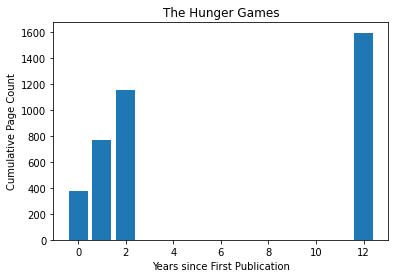

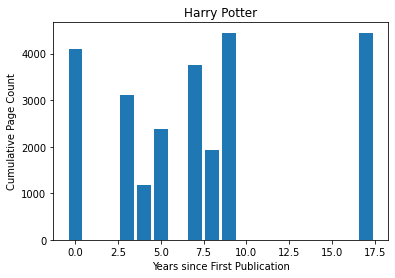

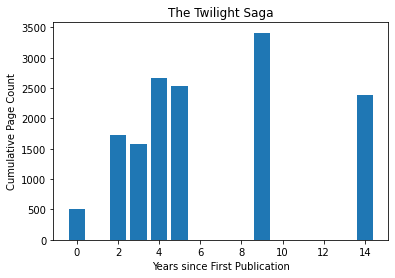

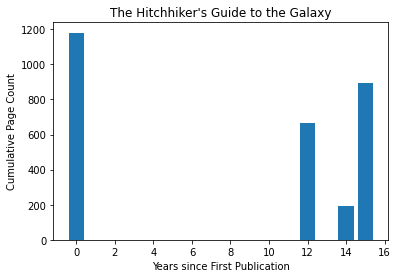

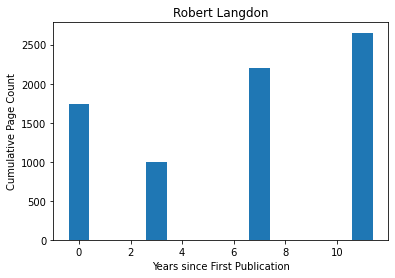

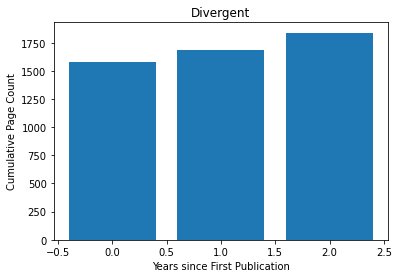

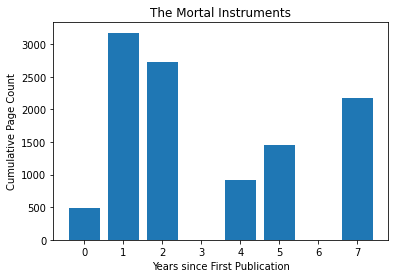

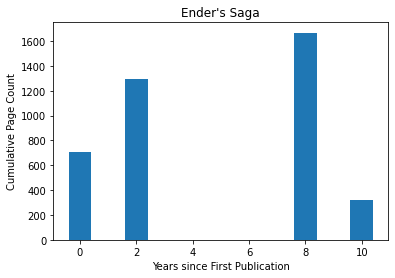

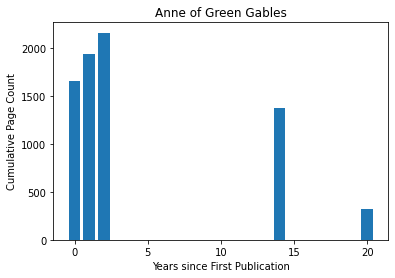

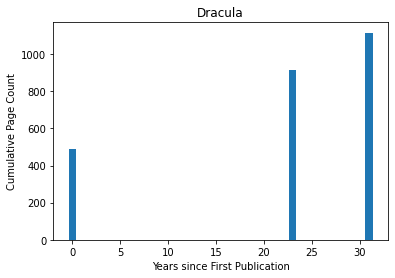

In [32]:
for key in series.keys():
  x= []
  y = []
  df = sub_df[sub_df.index.isin(series[key])]
  df['PublishingDate'] = pd.to_datetime([i.replace('th', '') for i in df['PublishingDate']])
  df['NumberofPages'] = pd.to_numeric(df['NumberofPages'])
  df.sort_values(['PublishingDate'])
  num_pages = 0
  for i in df.index:
    x.append(df['PublishingDate'][i].year - min(df['PublishingDate']).year)
    num_pages = num_pages + df['NumberofPages'][i]
    y.append(num_pages)
  y.sort()
  plt.bar(x, y)
  plt.title(key)
  plt.ylabel('Cumulative Page Count')
  plt.xlabel('Years since First Publication')
  plt.show()

As we can see the nice visualization failed for most of the series, because unfortunately, the publications years are not exact. For example, 'Harry Potter #1' according to our data has been published after 'Harry Potter #3', which is not true, but it probably depends on the edition.

# 5. Algorithmic Question

## 1. Write a recursive program that, given a string, computes the length of the subsequence of maximum length that is in alphabetical order. 
Try some examples. Are the examples of short strings correct? Can you find examples that your algorithm does not terminate in reasonable time?

To calculate the maximum length of a subsequence of characters that is in alphabetical order we created three functions as follows:

`alphabet_pos`: Receives a string and changes the characters by positions of the letters in the alphabet (mapping).

`max_len_sub_alpha_recursive`: Receives a position ($i$) of the character where the string is included, and a list representing the numbers mapped from letters. This is a recursive function that evaluates the maximum length of a subsequence of characters that is in alphabetical order that finishes in the letter of the $i^{th}$ position of the string.

`review_string`: Receives a string and executes the `max_len_sub_alpha` function for each character of the string ($n$ times).

All the previous functions can be found in the file our_functions.py.

In [ ]:
start_time = time.time()
# Set the desired string
string = "ABCDE"
# Apply function to string
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.review_string(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 5
--- 0.0 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KBEAXCZ"
# Apply function to string
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.review_string(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 4
--- 0.0 seconds ---


Looking at the two short examples, we can see that the results are correct since considering the string ABCDE the maximum length of a subsequence of characters that is in alphabetical order is 5. Also, regarding the string K**BE**A**X**C**Z**, the maximum length of a subsequence of characters that is in alphabetical order is 4.

In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSL"
# Apply function to string
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.review_string(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 6
--- 0.0019936561584472656 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSLKJHDSAKJDSAADSHJHGDSAJHGDSAJDSAJH"
# Apply function to string
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.review_string(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 6
--- 0.023902177810668945 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSLKJHDSAKJDSAADSHJHGDSAJHGDSAJDSAJHGDSAJHGJHDSKJHLSAKJHDSKJHDSAKJHSAKJWWIUYSKAKJHDLKJHSAB"
# Apply function to string
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.review_string(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 10
--- 3.685804605484009 seconds ---


Now, we considered 3 more examples, where we can see how the longer the string, the larger the execution time is. It makes us believe that the complexity of the recursive program could be exponential.

## 2. Show that the running time of the algorithm is exponential.

Let's consider $T(N)$ as the running time of the algorithm for the given length of the string ($N$). Taking into account that the function `max_len_sub_alpha_recursive` evaluates the maximum length of a subsequence of characters that is in alphabetical order that finishes in the letter of the  $i^{th}$ position of the string, it can be shown that:


$T(N) = T(N-1) + T(N-2) + T(N-3) + T(N-4) + ... + T(1) + T(0)$ 

Now, replacing $T(N-1)$ in the previous formula, we have that:

$T(N) = [T(N-2) + T(N-3) + T(N-4) + ... + T(1) + T(0)] + T(N-2) + T(N-3) + T(N-4) + ... + T(1) + T(0)$ 

$T(N) = 2[T(N-2) + T(N-3) + T(N-4) + ... + T(1) + T(0)]$

Again, replacing $T(N-1)$ in the previous formula, we have that:

$T(N) = 4[T(N-3) + T(N-4) + ... + T(1) + T(0)]$

If we continue to do the replacements in the previous formula, we get that:

$T(N) = 8[T(N-4) + ... + T(1) + T(0)]$

$T(N) = 16[T(N-5) + ... + T(1) + T(0)]$

$T(N) = 2^î[T(N-(i-1)]$

Finally, when taking the value of N we get:

$T(N) = 2^N[T(N-(N-1)]$

$T(N) = 2^N[T(1)]$

$T(N) = 2^N$

In the end, we obtained that the complexity of the algorithm is $O(2^n)$

But, it is important to take into account that we executed the previous algorithm $n$ times, that corresponds to each letter of the substring. The latter means that the final complexity of the algorithm is $O(n2^n)$. Effectively, the running time of the algorithm is exponential.

## 3. Write a program that computes the length of the subsequence of maximum length, using dynamic programming.

To calculate the maximum length of a subsequence of characters that is in alphabetical order, but using dynamic programming, we created one functions as follows:

`max_len_sub_alpha_dyn_prog`: Receives a string and maps its letters to numbers (using the function `alphabet_pos`). Later we defined an auxiliary array to store the maximum length that is finding when visiting the positions of the arrays with two for loops to evaluate the conditions defined for a subsequence to be in alphabetical order. 

The previous function can be found in the file our_functions.py.

In [ ]:
start_time = time.time()
# Set the desired string
string = "ABCDE"
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.max_len_sub_alpha_dyn_prog(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 5
--- 0.0009949207305908203 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KBEAXCZ"
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.max_len_sub_alpha_dyn_prog(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 4
--- 0.0009925365447998047 seconds ---


Looking at the two short examples, we can see that the results are correct since considering the string ABCDE the maximum length of a subsequence of characters that is in alphabetical order is 5. Besides, regarding the string K**BE**A**X**C**Z**, the maximum length of a subsequence of characters that is in alphabetical order is 4. The results are consistent with those obtained with the recursive algorithm.

In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSL"
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.max_len_sub_alpha_dyn_prog(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 6
--- 0.0009989738464355469 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSLKJHDSAKJDSAADSHJHGDSAJHGDSAJDSAJH"
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.max_len_sub_alpha_dyn_prog(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 6
--- 0.0009565353393554688 seconds ---


In [ ]:
start_time = time.time()
# Set the desired string
string = "KJHDSALKJHALJHFDKJDLKHSLKJHDSAKJDSAADSHJHGDSAJHGDSAJDSAJHGDSAJHGJHDSKJHLSAKJHDSKJHDSAKJHSAKJWWIUYSKAKJHDLKJHSAB"
print("The maximum length of a subsequence of characters that is in alfabetical order is", our_functions.max_len_sub_alpha_dyn_prog(string))
print("--- %s seconds ---" % (time.time() - start_time))

The maximum length of a subsequence of characters that is in alfabetical order is 10
--- 0.0009975433349609375 seconds ---


Finally, considering the same examples that in the previous exercise of the application of the recursive program, the execution time remains almost the same when increasing the number of letters considerably in the string. It shows that the dynamic program is way better than the recursive one since the complexity of the former is of polynomial order.

## 4. What is its runtime complexity?

With the previous algorithm, we can see that: 

- The first for loop goes from the second letter to the $n^{th}$ letter ($n$ is the length of the string). The previous means that it visits $n - 1$ letters. 
- The second for loop (that is contained in the first loop) goes from the first letter to the $i^{th}$. That means that, when $i = n$, it will go from the first letter to the $(n-1)^{th}$ letter.

Then, the running time can be seen as:

$T(N) <= (N-1) * (N-1)$

$T(N) <= (N^2 - 2N + 1)$

And taking the worst case, we have that the running time is:
$O(n^2)$

# BONUS

To prove that given

$X[i] =$ "the length of the longest sequence of characters in alphabetical order that terminates at the $i^{th}$ character".

$X[i] = 1 + max(X[j]; j = 0, ..., i-1 ,$ such that $S[j]<S[i])$

$X[i] = 1,$ if there does not exist such a j

We will use the induction approach as follows:

- First, we prove the base case. It is that $X[1] = 1$. This one is correct because it is taking the first element as a subsequence of itself of length 1.

- Now we use an inductive case. For that, we can assume that $X[1], ..., X[i-1]$ are correct.
- Then, at index $i$ (the next index) the first possible subsequence is the element $S[i]$ itself of length 1.
- Another possibility is a subsequence starting before and finishing at $i$, with the last index included being $j$.
- The latter only happens when $S[j] < S[i]$, because the order needs to be alphabetical.
- If the previous occurs, then its maximum length is $X[j] + 1$ since we appended the letter at index $i$. 
- So $X[i]$ is correct because the algorithm calculates the maximum of all these possibilities.